# Lecture 21 - LINEAR DATA FITTING WITH UNCERTANTIES - HW 10

As scientists one of our many checks is to fit data to models.  Here, we will begin first by learning how to fit data with uncertanties to a linear fit (slope and intercept, and uncertanties) by using the python `scipy` module. 

In [43]:
#standard importing
from matplotlib import pyplot as plt
import numpy as np
import scipy.optimize as opt

In [46]:
#Read in the data to a numpy array
data = np.genfromtxt("LinearFit_data.txt", names=True, dtype=None)

# print out all columns we just got for free
data.dtype

dtype([('X', '<f8'), ('Y', '<f8'), ('Y_ERR', '<f8'), ('Z', '<f8'), ('Z_ERR', '<f8')])

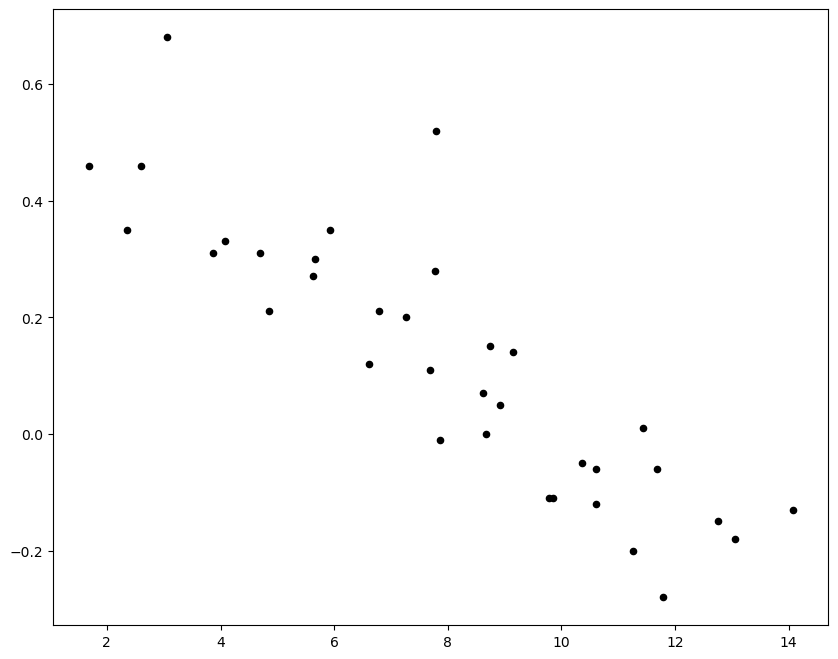

In [47]:
#First let's see what this data looks like
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black')

# Cool! The data actually looks pretty linear so we can assume the function we are fitting *is* linear

In [49]:
# let's make a linear function the normal way
def linear(x, m, b):
    return m * x + b

raw:  -0.06190219340819535 0.6174204496164701
raw:  [ 3.63943117e-05 -2.88586095e-04] [-0.00028859  0.0026655 ]


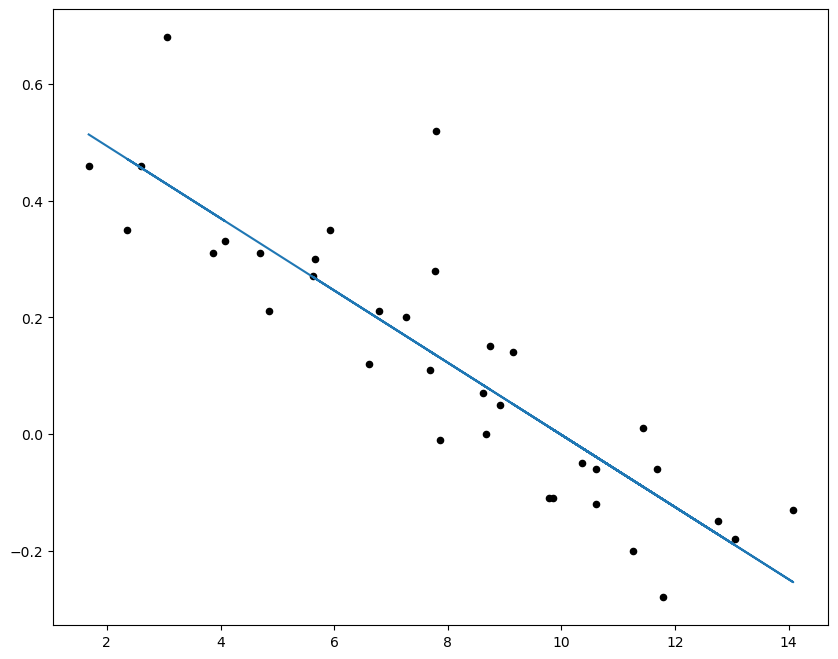

In [50]:
# let's do a linear fit to the data

popt, pcov = opt.curve_fit(linear, data['X'], data['Y'])
print("raw: ", *popt)
print("raw: ", *pcov)


fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black')
ax.plot(data['X'],linear(data['X'], *popt))


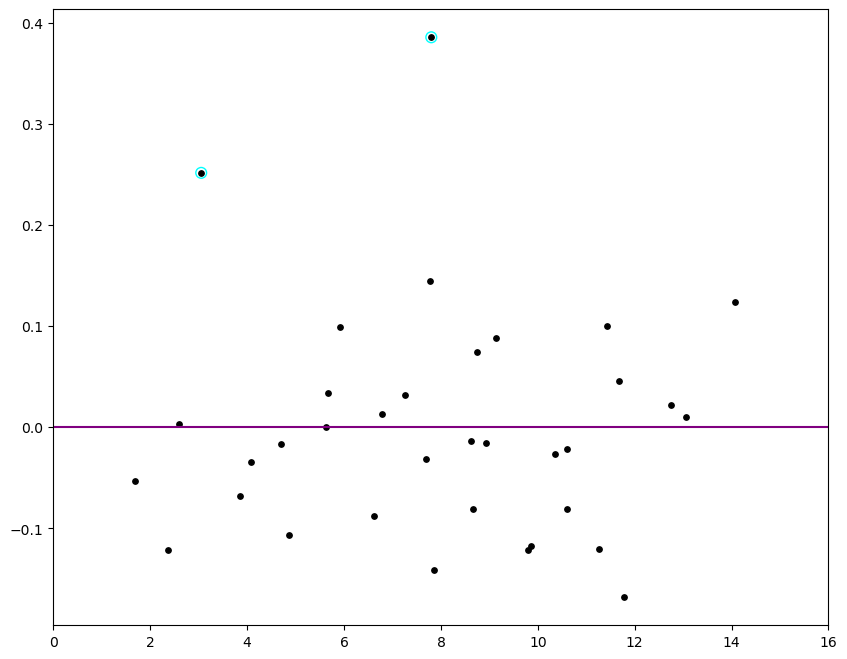

In [51]:
#Let's look into wich data are way off the fit.

residual = data['Y']-linear(data['X'],*popt)
x = np.linspace(0,20,1000)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.scatter(data['X'],residual,s=15,c='black')
ax.plot(x,x*0.0,color='purple')
ax.set_xlim(0,16)

outlier = np.absolute(residual)>0.20
ax.scatter(data['X'][outlier],residual[outlier],s=60,edgecolor='cyan',facecolor='none')


raw:  -0.06190219340819535 0.6174204496164701
outliers accounted for:  -0.05813182372341274 0.5703220760024399


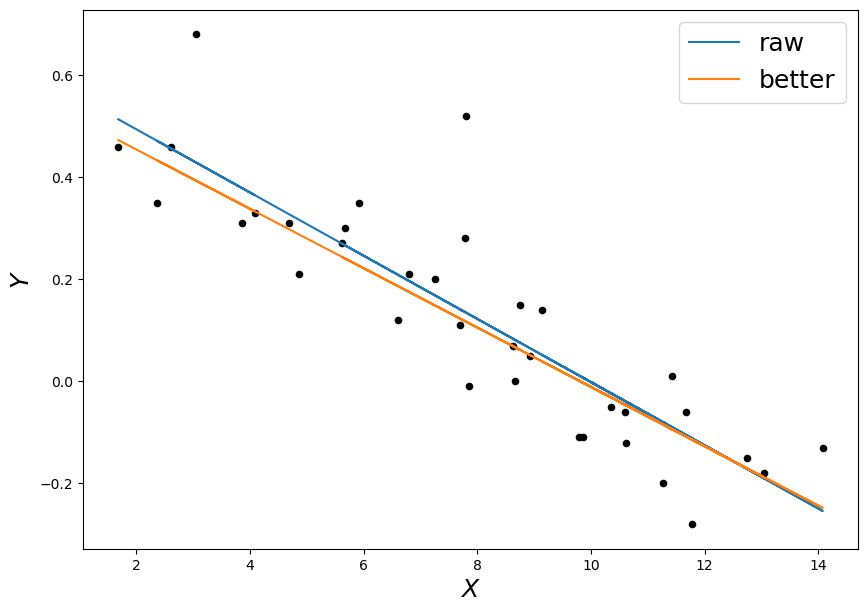

In [52]:
# our values for the raw data above:
# slope:    -0.058187
# intercept: 0.565351
popt, pcov = opt.curve_fit(linear, data['X'], data['Y'])
print("raw: ", *popt)

# we can use curve_fit to de-weight outliers automatically

# note, result is dependent on choice of loss function
# need to see method to trf in order to use least_squares instead of leastsq
popt_clean, pcov = opt.curve_fit(linear, data['X'], data['Y'], method='trf', 
                                 loss='arctan', f_scale=0.20)
print("outliers accounted for: ", *popt_clean)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black',zorder=2)
# cleaner error bars than last time, play around with the parameters
#ax.errorbar(data['X'],data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
#            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

-0.056065582940337505 0.5500877317993452


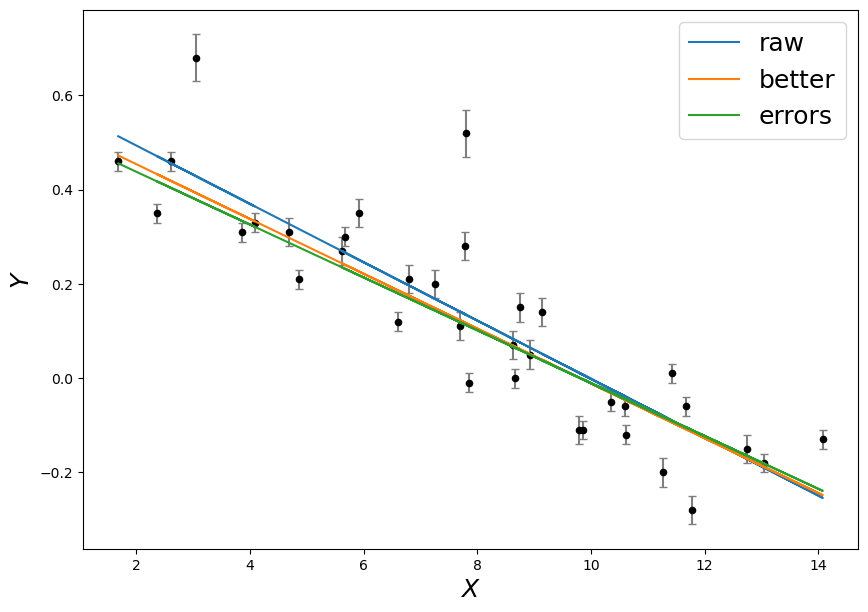

In [53]:
# lets account for the errors
# by pasing sigma, scipy knows to weight data according to their errors 
# naturally, sigma is expected to be the same size and correspond to y
# notice: this only accounts for y error
popt_err, pcov = opt.curve_fit(linear, data['X'], data['Y'], sigma=data['Y_ERR'])
print(*popt_err)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'],data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with out fits
ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'],linear(data['X'], *popt_err), label='errors')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

mean slope: -0.0619, mean intercept: 0.6178


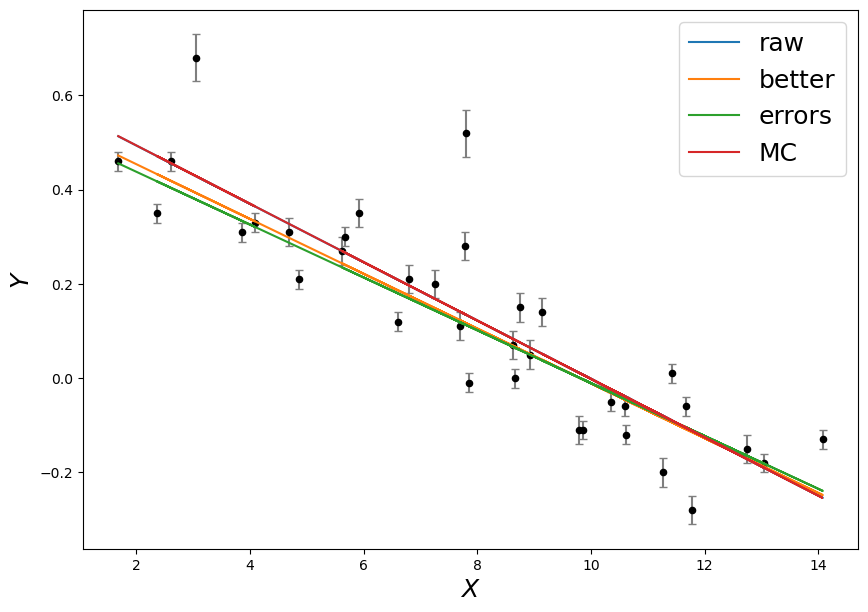

In [54]:
# Does this accurately explore the parameter space though?
# And what is the uncertainty on our data?
# What if we had x error bars?

# we'll explore a method utilizing the common "monte carlo" approach
def mcFit(x, y, y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights = np.random.randn(len(y))

        y_adj = y + y_err*weights
        x_adj = x  

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

slope, intercept = mcFit(data['X'], data['Y'], data['Y_ERR'])

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

In [55]:
# oh right, those outliers.

mask = data['Y'] < 0.5 

xdat = data['X'][mask]
ydat = data['Y'][mask]
ydat_err = data['Y_ERR'][mask]

print("data size: ", len(xdat))

slope, intercept = mcFit(xdat, ydat, ydat_err)

print('slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.std(slope),
                                                                          np.mean(intercept)))
print("\n")
# lets discuss monte carlo methods a little
for i in range(20):
    slope, intercept = mcFit(xdat, ydat, ydat_err)
    print("slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}".format(np.mean(slope), np.std(slope), 
                                                                          np.mean(intercept)))

# so what we see that our answer changes slightly, but its within the standard deviation
# of each set of measurements. So we can quote a reliable answer, with a reliable uncertainty

data size:  33
slope: -0.0579 $\pm$ 0.0012, mean intercept: 0.5657


slope: -0.0579 $\pm$ 0.0012, mean intercept: 0.5655
slope: -0.0578 $\pm$ 0.0012, mean intercept: 0.5654
slope: -0.0579 $\pm$ 0.0013, mean intercept: 0.5652
slope: -0.0579 $\pm$ 0.0012, mean intercept: 0.5655
slope: -0.0578 $\pm$ 0.0012, mean intercept: 0.5653
slope: -0.0579 $\pm$ 0.0013, mean intercept: 0.5663
slope: -0.0579 $\pm$ 0.0012, mean intercept: 0.5656
slope: -0.0578 $\pm$ 0.0012, mean intercept: 0.5649
slope: -0.0578 $\pm$ 0.0012, mean intercept: 0.5650
slope: -0.0578 $\pm$ 0.0012, mean intercept: 0.5654
slope: -0.0578 $\pm$ 0.0012, mean intercept: 0.5648
slope: -0.0579 $\pm$ 0.0012, mean intercept: 0.5659
slope: -0.0579 $\pm$ 0.0012, mean intercept: 0.5655
slope: -0.0578 $\pm$ 0.0012, mean intercept: 0.5650
slope: -0.0577 $\pm$ 0.0013, mean intercept: 0.5642
slope: -0.0578 $\pm$ 0.0012, mean intercept: 0.5647
slope: -0.0580 $\pm$ 0.0012, mean intercept: 0.5664
slope: -0.0579 $\pm$ 0.0013, mean intercept: 0.

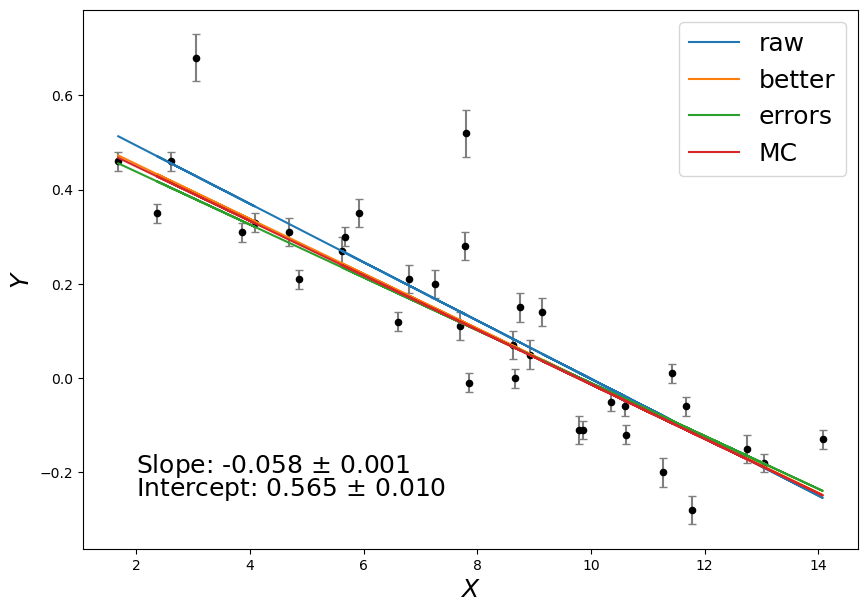

In [56]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

slope, intercept = mcFit(xdat, ydat, ydat_err)

# along with out fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

ax.text(2, -0.2, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
ax.text(2, -0.25, "Intercept: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

## Homework #10

**REMINDER:** *All coding assignment will be turned in as .ipynb files, to the same PHYS_X0223 repository on GitHub.*   
*They should be turned in with the following naming:*
    
    Lastname_Firstinitial_25_HW10.ipynb

### Problem 1:
We can't know the x data perfectly suppose the data have uniform x errors of 0.5 use the MC technique to estimate the slope *AND* the uncertainty taking into account these errors.



data size:  33


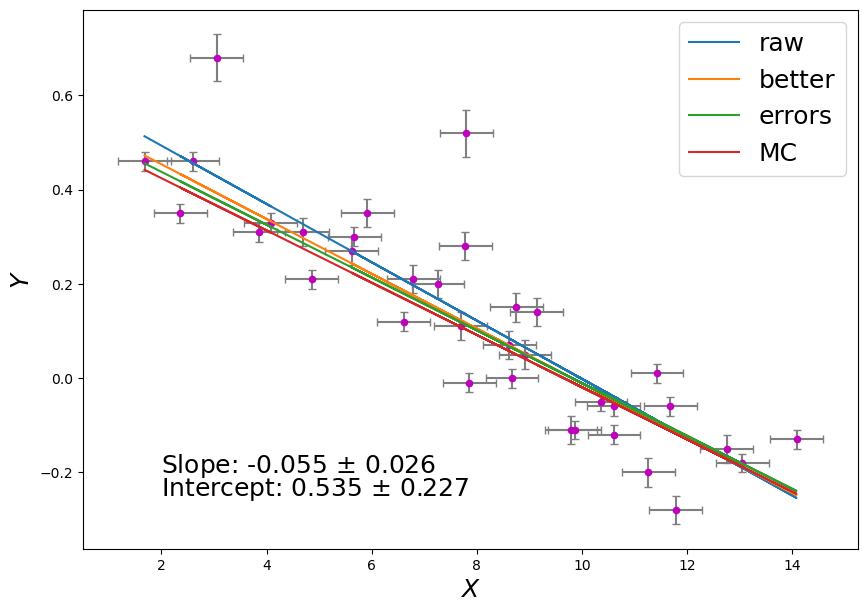

mean slope: -0.0554518518501049 mean intercept: 0.5354091906921263


In [57]:
def mcFit(x, y, x_err, y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights_y = np.random.randn(len(y))
        weights_x = np.random.randn(len(y))

        y_adj = y + y_err*weights_y
        x_adj = x + x_err*weights_x 

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

mask = data['Y'] < 0.5 

xdat = data['X'][mask]
ydat = data['Y'][mask]
xdat_err = 0.5
ydat_err = data['Y_ERR'][mask]

print("data size: ", len(xdat))

slope, intercept = mcFit(xdat, ydat, ydat_err,  xdat_err)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='m',zorder=2)
ax.errorbar(data['X'], data['Y'], yerr=data['Y_ERR'],  xerr =0.5, c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

ax.text(2, -0.2, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
ax.text(2, -0.25, "Intercept: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()


print("mean slope:", (np.mean(slope)), "mean intercept:", np.mean(intercept))


### Problem 2:
Repeat problem #1 , but change the errors INCREASE as we move away from X = 8 (as they do) to be precise: suppose X_ERR = |x - 8| /10, e.g. it increases by .1 per unit.

Plot both slopes (Problem 1 & 2). How does the fit change? 

data size:  33


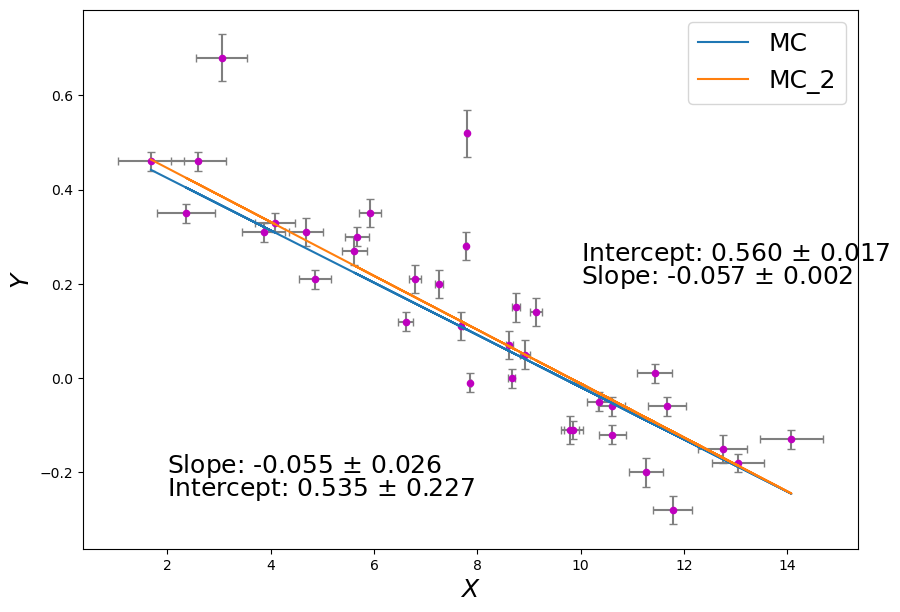

mean slope: -0.0554518518501049 mean intercept: 0.5354091906921263
mean slope: -0.057161629060269135 mean intercept: 0.5601046927752125


In [58]:
def mcFit(x, y, x_err, y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights_y = np.random.randn(len(y))
        weights_x = np.random.randn(len(y))

        y_adj = y + y_err*weights_y
        x_adj = x + x_err*weights_x 

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

mask = data['Y'] < 0.5 

xdat = data['X'][mask]
ydat = data['Y'][mask]
xdat_errP2 = abs(data['X'][mask] - 8)/10
ydat_err = data['Y_ERR'][mask]

print("data size: ", len(xdat))

slope_2, intercept_2 = mcFit(xdat, ydat,  xdat_errP2, ydat_err)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='m',zorder=2)
ax.errorbar(data['X'], data['Y'], yerr=data['Y_ERR'],  xerr = abs(data['X'] - 8)/10, c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')
ax.plot(data['X'], linear(data['X'], np.mean(slope_2), np.mean(intercept_2)), label='MC_2')

ax.text(2, -0.2, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
ax.text(2, -0.25, "Intercept: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)

ax.text(10, 0.2, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope_2), np.std(slope_2)), fontsize=18)
ax.text(10, 0.25, "Intercept: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept_2), np.std(intercept_2)), fontsize=18)

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()


print("mean slope:", (np.mean(slope)), "mean intercept:", np.mean(intercept))
print("mean slope:", (np.mean(slope_2)), "mean intercept:", np.mean(intercept_2))


### Problem 3: 
Repeat problem 1 & 2, but now anaylze for X vs. Z data, including both uniform 0.5 and X_ERR = |x - 8| /10 uncertainties.

data size:  33


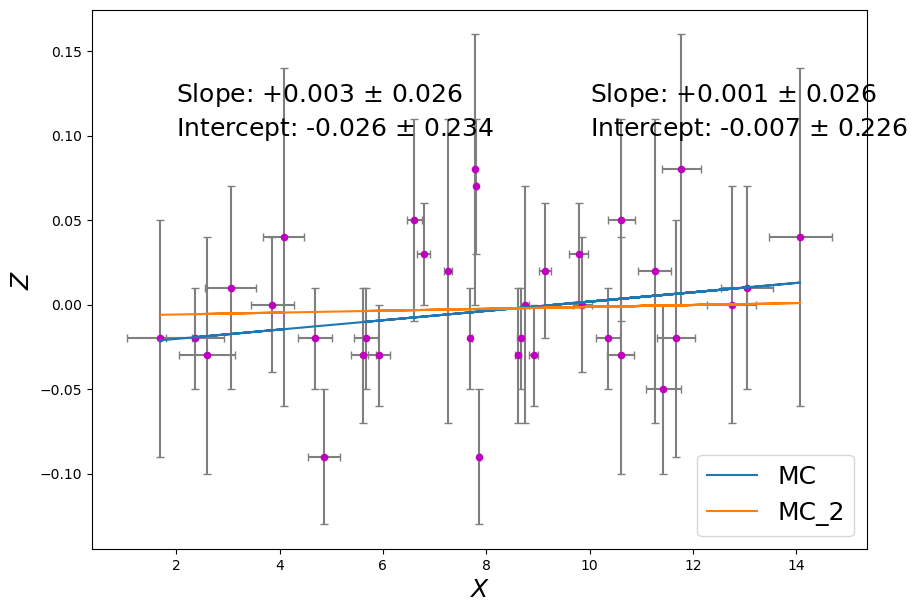

mean slope: 0.002758708248568735 mean intercept: -0.025832233313107047
mean slope: 0.0005621522804987962 mean intercept: -0.00700043488604325


In [64]:
def mcFit(x, y, x_err, y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights_y = np.random.randn(len(y))
        weights_x = np.random.randn(len(y))

        y_adj = y + y_err*weights_y
        x_adj = x + x_err*weights_x 

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

mask = data['Y'] < 0.5 

xdat = data['X'][mask]
zdat = data['Z'][mask]
xdat_err = 0.5
xdat_errP2 = abs(data['X'][mask] - 8)/10
zdat_err = data['Z_ERR'][mask]

print("data size: ", len(xdat))

slope_z, intercept_z = mcFit(xdat, zdat, zdat_err,  0.5)
slope_z2, intercept_z2 = mcFit(xdat, zdat, zdat_err,  xdat_errP2)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Z'],s=20,c='m',zorder=2)
ax.errorbar(data['X'], data['Z'], yerr=data['Z_ERR'],  xerr = abs(data['X'] - 8)/10, c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], np.mean(slope_z), np.mean(intercept_z)), label='MC')
ax.plot(data['X'], linear(data['X'], np.mean(slope_z2), np.mean(intercept_z2)), label='MC_2')



ax.text(2, 0.12, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope_z), np.std(slope_z)), fontsize=18)
ax.text(2, 0.1, "Intercept: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept_z), np.std(intercept_z)), fontsize=18)

ax.text(10, 0.12, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope_z2), np.std(slope_z2)), fontsize=18)
ax.text(10, 0.1, "Intercept: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept_z2), np.std(intercept_z2)), fontsize=18)

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()


print("mean slope:", (np.mean(slope_z)), "mean intercept:", np.mean(intercept_z))
print("mean slope:", (np.mean(slope_z2)), "mean intercept:", np.mean(intercept_z2))
